In [1]:
import pandas as pd
import numpy
import requests
import json
import datetime
import dateutil.parser
import pytz
from typing import Optional, Union
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# An api key is emailed to you when you sign up to a plan
# Get a free API key at https://api.the-odds-api.com/
API_KEY = 'ccb83d4bc10da89dbfa3dc2135ba9c1a'

SPORT = 'upcoming' # use the sport_key from the /sports endpoint below, or use 'upcoming' to see the next 8 games across all sports

REGIONS = 'us' # uk | us | eu | au. Multiple can be specified if comma delimited

MARKETS = 'h2h' # h2h | spreads | totals. Multiple can be specified if comma delimited

ODDS_FORMAT = 'american' # decimal | american

DATE_FORMAT = 'iso' # iso | unix

In [3]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#
# First get a list of in-season sports
#   The sport 'key' from the response can be used to get odds in the next request
#
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

sports_response = requests.get(
    'https://api.the-odds-api.com/v4/sports',
    params={
        'api_key': API_KEY
    }
)


if sports_response.status_code != 200:
    print(f'Failed to get sports: status_code {sports_response.status_code}, response body {sports_response.text}')

else:
    print('List of in season sports:', sports_response.json())


List of in season sports: [{'key': 'americanfootball_cfl', 'group': 'American Football', 'title': 'CFL', 'description': 'Canadian Football League', 'active': True, 'has_outrights': False}, {'key': 'americanfootball_ncaaf', 'group': 'American Football', 'title': 'NCAAF', 'description': 'US College Football', 'active': True, 'has_outrights': False}, {'key': 'americanfootball_ncaaf_championship_winner', 'group': 'American Football', 'title': 'NCAAF Championship Winner', 'description': 'US College Football Championship Winner', 'active': True, 'has_outrights': True}, {'key': 'americanfootball_nfl', 'group': 'American Football', 'title': 'NFL', 'description': 'US Football', 'active': True, 'has_outrights': False}, {'key': 'americanfootball_nfl_preseason', 'group': 'American Football', 'title': 'NFL Preseason', 'description': 'US Football', 'active': True, 'has_outrights': False}, {'key': 'americanfootball_nfl_super_bowl_winner', 'group': 'American Football', 'title': 'NFL Super Bowl Winner'

In [4]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#
# Now get a list of live & upcoming games for the sport you want, along with odds for different bookmakers
# This will deduct from the usage quota
# The usage quota cost = [number of markets specified] x [number of regions specified]
# For examples of usage quota costs, see https://the-odds-api.com/liveapi/guides/v4/#usage-quota-costs

SPORT = 'baseball_mlb'

odds_response = requests.get(
    f'https://api.the-odds-api.com/v4/sports/{SPORT}/odds',
    params={
        'api_key': API_KEY,
        'regions': REGIONS,
        'markets': MARKETS,
        'oddsFormat': ODDS_FORMAT,
        'dateFormat': DATE_FORMAT,
    }
)

if odds_response.status_code != 200:
    print(f'Failed to get odds: status_code {odds_response.status_code}, response body {odds_response.text}')

else:
    odds_json = odds_response.json()
    print('Number of events:', len(odds_json))
    print(odds_json)


Number of events: 29
[{'id': '73f8f2e10341979113e6023096357e08', 'sport_key': 'baseball_mlb', 'sport_title': 'MLB', 'commence_time': '2024-08-02T22:41:00Z', 'home_team': 'Pittsburgh Pirates', 'away_team': 'Arizona Diamondbacks', 'bookmakers': [{'key': 'fanduel', 'title': 'FanDuel', 'last_update': '2024-08-02T23:29:29Z', 'markets': [{'key': 'h2h', 'last_update': '2024-08-02T23:29:29Z', 'outcomes': [{'name': 'Arizona Diamondbacks', 'price': -2500}, {'name': 'Pittsburgh Pirates', 'price': 900}]}]}, {'key': 'draftkings', 'title': 'DraftKings', 'last_update': '2024-08-02T23:24:34Z', 'markets': [{'key': 'h2h', 'last_update': '2024-08-02T23:24:34Z', 'outcomes': [{'name': 'Arizona Diamondbacks', 'price': -1750}, {'name': 'Pittsburgh Pirates', 'price': 850}]}]}, {'key': 'williamhill_us', 'title': 'Caesars', 'last_update': '2024-08-02T23:29:28Z', 'markets': [{'key': 'h2h', 'last_update': '2024-08-02T23:29:28Z', 'outcomes': [{'name': 'Arizona Diamondbacks', 'price': -2000}, {'name': 'Pittsburgh P

In [5]:
# Check the usage quota
print('Remaining requests', odds_response.headers['x-requests-remaining'])
print('Used requests', odds_response.headers['x-requests-used'])


Remaining requests 489
Used requests 11


In [6]:
#set up the columns
columns = [
        'event_id', 'sport_key', 'sport_title', 'commence_time',
        'home_team', 'away_team', 'bookmaker_key', 'bookmaker_title',
        'bookmaker_last_update', 'market_key', 'market_last_update',
        'outcome_name', 'outcome_price']

df = pd.DataFrame(columns=columns)

# Prepare list to collect all rows
all_rows = []

# Iterate over each event
for event in odds_json:
        event_id = event['id']
        sport_key = event['sport_key']
        sport_title = event['sport_title']
        commence_time = event['commence_time']
        home_team = event['home_team']
        away_team = event['away_team']

        # Iterate over each bookmaker
        for bookmaker in event['bookmakers']:
            bookmaker_key = bookmaker['key']
            bookmaker_title = bookmaker['title']
            bookmaker_last_update = bookmaker['last_update']

            # Iterate over each market
            for market in bookmaker['markets']:
                market_key = market['key']
                market_last_update = market['last_update']

                # Iterate over each outcome
                for outcome in market['outcomes']:
                    outcome_name = outcome['name']
                    outcome_price = outcome['price']

                    # Append the row to the list
                    all_rows.append([
                        event_id, sport_key, sport_title, commence_time,
                        home_team, away_team, bookmaker_key, bookmaker_title,
                        bookmaker_last_update, market_key, market_last_update,
                        outcome_name, outcome_price
                    ])
for i, row in enumerate(all_rows):
    df.loc[i] = row

In [7]:
df

,event_id,sport_key,sport_title,commence_time,home_team,away_team,bookmaker_key,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price
0,73f8f2e10341979113e6023096357e08,baseball_mlb,MLB,2024-08-02T22:41:00Z,Pittsburgh Pirates,Arizona Diamondbacks,fanduel,FanDuel,2024-08-02T23:29:29Z,h2h,2024-08-02T23:29:29Z,Arizona Diamondbacks,-2500
1,73f8f2e10341979113e6023096357e08,baseball_mlb,MLB,2024-08-02T22:41:00Z,Pittsburgh Pirates,Arizona Diamondbacks,fanduel,FanDuel,2024-08-02T23:29:29Z,h2h,2024-08-02T23:29:29Z,Pittsburgh Pirates,900
2,73f8f2e10341979113e6023096357e08,baseball_mlb,MLB,2024-08-02T22:41:00Z,Pittsburgh Pirates,Arizona Diamondbacks,draftkings,DraftKings,2024-08-02T23:24:34Z,h2h,2024-08-02T23:24:34Z,Arizona Diamondbacks,-1750
3,73f8f2e10341979113e6023096357e08,baseball_mlb,MLB,2024-08-02T22:41:00Z,Pittsburgh Pirates,Arizona Diamondbacks,draftkings,DraftKings,2024-08-02T23:24:34Z,h2h,2024-08-02T23:24:34Z,Pittsburgh Pirates,850
4,73f8f2e10341979113e6023096357e08,baseball_mlb,MLB,2024-08-02T22:41:00Z,Pittsburgh Pirates,Arizona Diamondbacks,williamhill_us,Caesars,2024-08-02T23:29:28Z,h2h,2024-08-02T23:29:28Z,Arizona Diamondbacks,-2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,9a344ae79cdd293ec9dd35bb0d437908,baseball_mlb,MLB,2024-08-04T01:40:00Z,Seattle Mariners,Philadelphia Phillies,draftkings,DraftKings,2024-08-02T23:24:34Z,h2h,2024-08-02T23:24:34Z,Seattle Mariners,-125
404,9a344ae79cdd293ec9dd35bb0d437908,baseball_mlb,MLB,2024-08-04T01:40:00Z,Seattle Mariners,Philadelphia Phillies,fanduel,FanDuel,2024-08-02T23:29:29Z,h2h,2024-08-02T23:29:29Z,Philadelphia Phillies,100
405,9a344ae79cdd293ec9dd35bb0d437908,baseball_mlb,MLB,2024-08-04T01:40:00Z,Seattle Mariners,Philadelphia Phillies,fanduel,FanDuel,2024-08-02T23:29:29Z,h2h,2024-08-02T23:29:29Z,Seattle Mariners,-118
406,9a344ae79cdd293ec9dd35bb0d437908,baseball_mlb,MLB,2024-08-04T01:40:00Z,Seattle Mariners,Philadelphia Phillies,williamhill_us,Caesars,2024-08-02T23:29:28Z,h2h,2024-08-02T23:29:28Z,Philadelphia Phillies,105


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 408 entries, 0 to 407
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   event_id               408 non-null    object
 1   sport_key              408 non-null    object
 2   sport_title            408 non-null    object
 3   commence_time          408 non-null    object
 4   home_team              408 non-null    object
 5   away_team              408 non-null    object
 6   bookmaker_key          408 non-null    object
 7   bookmaker_title        408 non-null    object
 8   bookmaker_last_update  408 non-null    object
 9   market_key             408 non-null    object
 10  market_last_update     408 non-null    object
 11  outcome_name           408 non-null    object
 12  outcome_price          408 non-null    int64 
dtypes: int64(1), object(12)
memory usage: 60.8+ KB


In [9]:
df2= df.drop(columns = ['event_id', 'commence_time', 'bookmaker_key'])
df2

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price
0,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,FanDuel,2024-08-02T23:29:29Z,h2h,2024-08-02T23:29:29Z,Arizona Diamondbacks,-2500
1,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,FanDuel,2024-08-02T23:29:29Z,h2h,2024-08-02T23:29:29Z,Pittsburgh Pirates,900
2,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,DraftKings,2024-08-02T23:24:34Z,h2h,2024-08-02T23:24:34Z,Arizona Diamondbacks,-1750
3,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,DraftKings,2024-08-02T23:24:34Z,h2h,2024-08-02T23:24:34Z,Pittsburgh Pirates,850
4,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,Caesars,2024-08-02T23:29:28Z,h2h,2024-08-02T23:29:28Z,Arizona Diamondbacks,-2000
...,...,...,...,...,...,...,...,...,...,...
403,baseball_mlb,MLB,Seattle Mariners,Philadelphia Phillies,DraftKings,2024-08-02T23:24:34Z,h2h,2024-08-02T23:24:34Z,Seattle Mariners,-125
404,baseball_mlb,MLB,Seattle Mariners,Philadelphia Phillies,FanDuel,2024-08-02T23:29:29Z,h2h,2024-08-02T23:29:29Z,Philadelphia Phillies,100
405,baseball_mlb,MLB,Seattle Mariners,Philadelphia Phillies,FanDuel,2024-08-02T23:29:29Z,h2h,2024-08-02T23:29:29Z,Seattle Mariners,-118
406,baseball_mlb,MLB,Seattle Mariners,Philadelphia Phillies,Caesars,2024-08-02T23:29:28Z,h2h,2024-08-02T23:29:28Z,Philadelphia Phillies,105


In [10]:
# Convert the columns to datetime
df2['bookmaker_last_update'] = pd.to_datetime(df2['bookmaker_last_update'])
df2['market_last_update'] = pd.to_datetime(df2['market_last_update'])

# Format the datetime columns
df2['bookmaker_last_update'] = df2['bookmaker_last_update'].dt.strftime('%b %d, %H:%M')
df2['market_last_update'] = df2['market_last_update'].dt.strftime('%b %d, %H:%M')
df2

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price
0,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,FanDuel,"Aug 02, 23:29",h2h,"Aug 02, 23:29",Arizona Diamondbacks,-2500
1,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,FanDuel,"Aug 02, 23:29",h2h,"Aug 02, 23:29",Pittsburgh Pirates,900
2,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,DraftKings,"Aug 02, 23:24",h2h,"Aug 02, 23:24",Arizona Diamondbacks,-1750
3,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,DraftKings,"Aug 02, 23:24",h2h,"Aug 02, 23:24",Pittsburgh Pirates,850
4,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,Caesars,"Aug 02, 23:29",h2h,"Aug 02, 23:29",Arizona Diamondbacks,-2000
...,...,...,...,...,...,...,...,...,...,...
403,baseball_mlb,MLB,Seattle Mariners,Philadelphia Phillies,DraftKings,"Aug 02, 23:24",h2h,"Aug 02, 23:24",Seattle Mariners,-125
404,baseball_mlb,MLB,Seattle Mariners,Philadelphia Phillies,FanDuel,"Aug 02, 23:29",h2h,"Aug 02, 23:29",Philadelphia Phillies,100
405,baseball_mlb,MLB,Seattle Mariners,Philadelphia Phillies,FanDuel,"Aug 02, 23:29",h2h,"Aug 02, 23:29",Seattle Mariners,-118
406,baseball_mlb,MLB,Seattle Mariners,Philadelphia Phillies,Caesars,"Aug 02, 23:29",h2h,"Aug 02, 23:29",Philadelphia Phillies,105


In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 408 entries, 0 to 407
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   sport_key              408 non-null    object
 1   sport_title            408 non-null    object
 2   home_team              408 non-null    object
 3   away_team              408 non-null    object
 4   bookmaker_title        408 non-null    object
 5   bookmaker_last_update  408 non-null    object
 6   market_key             408 non-null    object
 7   market_last_update     408 non-null    object
 8   outcome_name           408 non-null    object
 9   outcome_price          408 non-null    int64 
dtypes: int64(1), object(9)
memory usage: 51.2+ KB


In [12]:
def av_odds(df):
    # Define key columns for grouping
    key_fields = ['home_team', 'away_team', 'bookmaker_title', 'outcome_name']

    # Perform aggregation by calculating the average outcome_price
    df_avg = df.groupby(key_fields, dropna=False).agg({
        'outcome_price': 'mean'  # Average outcome_price
    }).reset_index()

    # Sort the aggregated DataFrame by key fields
    df_avg.sort_values(['home_team','away_team'], inplace=True)

    return df_avg



In [13]:
df_avg_odds = av_odds(df2)
df_avg_odds

,home_team,away_team,bookmaker_title,outcome_name,outcome_price
0,Atlanta Braves,Miami Marlins,BetMGM,Atlanta Braves,-250.0
1,Atlanta Braves,Miami Marlins,BetMGM,Miami Marlins,195.0
2,Atlanta Braves,Miami Marlins,BetOnline.ag,Atlanta Braves,-248.0
3,Atlanta Braves,Miami Marlins,BetOnline.ag,Miami Marlins,220.0
4,Atlanta Braves,Miami Marlins,BetRivers,Atlanta Braves,-278.0
...,...,...,...,...,...
281,Washington Nationals,Milwaukee Brewers,FanDuel,Washington Nationals,318.0
282,Washington Nationals,Milwaukee Brewers,LowVig.ag,Milwaukee Brewers,-127.0
283,Washington Nationals,Milwaukee Brewers,LowVig.ag,Washington Nationals,117.0
284,Washington Nationals,Milwaukee Brewers,MyBookie.ag,Milwaukee Brewers,-568.5


In [14]:
#general average odds for the home team only
avg_odds = df2.groupby('home_team')['outcome_price'].mean()
avg_odds

,outcome_price
home_team,
Atlanta Braves,-20.318182
Chicago Cubs,-20.437500
Cincinnati Reds,-9.088235
Cleveland Guardians,-35.653846
Detroit Tigers,-21.785714
Houston Astros,-10.823529
Los Angeles Angels,-8.800000
Minnesota Twins,-23.444444
New York Yankees,-13.312500


In [15]:
#standard deviationon the home team only
std_dev_odds = df2.groupby('home_team')['outcome_price'].std()
std_dev_odds

,outcome_price
home_team,
Atlanta Braves,206.856147
Chicago Cubs,112.404608
Cincinnati Reds,127.634271
Cleveland Guardians,128.390324
Detroit Tigers,189.671854
Houston Astros,148.064579
Los Angeles Angels,127.678043
Minnesota Twins,253.562778
New York Yankees,169.568986


In [20]:
#min and max odds sorted by outcome_price
min_odds = df2.groupby('outcome_name')['outcome_price'].min().sort_values()
max_odds = df2.groupby('outcome_name')['outcome_price'].max().sort_values(ascending=False)
print(min_odds)
print(max_odds)

outcome_name
Arizona Diamondbacks    -2500
Milwaukee Brewers        -600
Minnesota Twins          -350
Detroit Tigers           -280
Atlanta Braves           -278
San Diego Padres         -200
New York Yankees         -190
Los Angeles Dodgers      -180
Houston Astros           -164
San Francisco Giants     -148
New York Mets            -148
Cincinnati Reds          -145
Kansas City Royals       -138
Cleveland Guardians      -135
Baltimore Orioles        -134
Seattle Mariners         -125
Chicago Cubs             -120
Pittsburgh Pirates       -120
Texas Rangers            -116
Boston Red Sox           -112
Philadelphia Phillies    -110
St. Louis Cardinals      -104
Washington Nationals      110
Los Angeles Angels        110
Toronto Blue Jays         117
Oakland Athletics         120
Tampa Bay Rays            130
Chicago White Sox         140
Colorado Rockies          154
Miami Marlins             200
Name: outcome_price, dtype: int64
outcome_name
Pittsburgh Pirates       950
Washington 

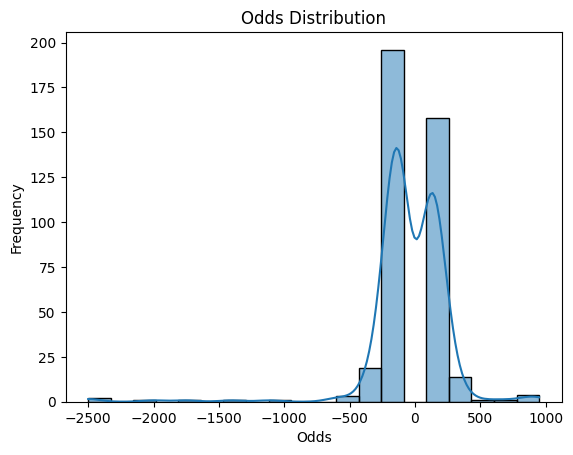

In [21]:
#number of times each team is placed within the odds
sns.histplot(df2['outcome_price'], bins=20, kde=True)
plt.xlabel('Odds')
plt.ylabel('Frequency')
plt.title('Odds Distribution')
plt.show()


In [22]:
home_odds = df2[df2['home_team'] == 'TeamName']['outcome_price'].mean()
away_odds = df2[df2['away_team'] == 'TeamName']['outcome_price'].mean()
print(home_odds)
print(away_odds)

nan
nan


In [23]:
# Grouping by 'bookmaker_title' and including 'home_team'
bookmaker_odds = df2.groupby(['bookmaker_title', 'home_team'])['outcome_price'].apply(list).reset_index()

# Display the odds
bookmaker_odds


,bookmaker_title,home_team,outcome_price
0,BetMGM,Atlanta Braves,"[-250, 200]"
1,BetMGM,Cincinnati Reds,"[115, -135, -145, 120]"
2,BetMGM,Cleveland Guardians,"[100, -125]"
3,BetMGM,Detroit Tigers,"[-275, 210]"
4,BetMGM,Houston Astros,"[-155, 130]"
...,...,...,...
139,MyBookie.ag,Pittsburgh Pirates,"[-1111, 575, -101, -120]"
140,MyBookie.ag,San Diego Padres,"[159, -189]"
141,MyBookie.ag,Seattle Mariners,"[-102, -115]"
142,MyBookie.ag,Texas Rangers,"[-106, -110]"


In [19]:
def calculate_implied_probability(odd):
    if odd < 0:
        return ((-1 * odd) / ((-1 * odd) + 100)) * 100
    else:
        return (100 / (odd + 100)) * 100

In [20]:
# Apply the function to calculate implied probability and add it to the DataFrame
df2['implied_probability'] = df2['outcome_price'].apply(calculate_implied_probability)
df2

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price,implied_probability
0,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,FanDuel,"Aug 02, 23:29",h2h,"Aug 02, 23:29",Arizona Diamondbacks,-2500,96.153846
1,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,FanDuel,"Aug 02, 23:29",h2h,"Aug 02, 23:29",Pittsburgh Pirates,900,10.000000
2,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,DraftKings,"Aug 02, 23:24",h2h,"Aug 02, 23:24",Arizona Diamondbacks,-1750,94.594595
3,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,DraftKings,"Aug 02, 23:24",h2h,"Aug 02, 23:24",Pittsburgh Pirates,850,10.526316
4,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,Caesars,"Aug 02, 23:29",h2h,"Aug 02, 23:29",Arizona Diamondbacks,-2000,95.238095
...,...,...,...,...,...,...,...,...,...,...,...
403,baseball_mlb,MLB,Seattle Mariners,Philadelphia Phillies,DraftKings,"Aug 02, 23:24",h2h,"Aug 02, 23:24",Seattle Mariners,-125,55.555556
404,baseball_mlb,MLB,Seattle Mariners,Philadelphia Phillies,FanDuel,"Aug 02, 23:29",h2h,"Aug 02, 23:29",Philadelphia Phillies,100,50.000000
405,baseball_mlb,MLB,Seattle Mariners,Philadelphia Phillies,FanDuel,"Aug 02, 23:29",h2h,"Aug 02, 23:29",Seattle Mariners,-118,54.128440
406,baseball_mlb,MLB,Seattle Mariners,Philadelphia Phillies,Caesars,"Aug 02, 23:29",h2h,"Aug 02, 23:29",Philadelphia Phillies,105,48.780488


In [22]:
 grouped = df2.groupby(['home_team', 'away_team', 'bookmaker_title'])[['implied_probability']].sum().reset_index()
 grouped

,home_team,away_team,bookmaker_title,implied_probability
0,Atlanta Braves,Miami Marlins,BetMGM,105.326877
1,Atlanta Braves,Miami Marlins,BetOnline.ag,102.514368
2,Atlanta Braves,Miami Marlins,BetRivers,104.314204
3,Atlanta Braves,Miami Marlins,BetUS,103.686636
4,Atlanta Braves,Miami Marlins,Bovada,106.267806
...,...,...,...,...
138,Washington Nationals,Milwaukee Brewers,Caesars,209.768492
139,Washington Nationals,Milwaukee Brewers,DraftKings,210.251898
140,Washington Nationals,Milwaukee Brewers,FanDuel,210.052447
141,Washington Nationals,Milwaukee Brewers,LowVig.ag,102.030086


In [30]:
def calculate_bookmaker_advantage(df):
    # Calculate implied probability for each outcome
    df['implied_probability'] = df['outcome_price'].apply(calculate_implied_probability)

    # Create a unique identifier for each game
    df['game_id'] = df['home_team'] + ' vs ' + df['away_team']

    # Pivot to get implied probability for home and away teams
    pivot_df = df.pivot_table(index='game_id', columns='outcome_name', values='implied_probability', aggfunc='sum').reset_index()

    # Merge the original DataFrame with the pivot DataFrame
    df = pd.merge(df, pivot_df, on='game_id', suffixes=('', '_total'))

    # Calculate bookmaker advantage as the sum of implied probabilities for home and away teams
    df['bookmaker_advantage'] = df.apply(lambda row: row.get(row['outcome_name'] + '_total', 0) - row['implied_probability'], axis=1)

    # Drop intermediate columns
    df.drop(columns=['implied_probability', 'game_id'] + [col for col in df.columns if '_total' in col], inplace=True, errors='ignore')

    return df

In [33]:
#Calculate the bookmaker's advantage and add it to the DataFrame
df2 = calculate_bookmaker_advantage(df2)
df2.head(10)

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price,...,Pittsburgh Pirates,San Diego Padres,San Francisco Giants,Seattle Mariners,St. Louis Cardinals,Tampa Bay Rays,Texas Rangers,Toronto Blue Jays,Washington Nationals,bookmaker_advantage
0,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,FanDuel,"Aug 02, 23:21",h2h,"Aug 02, 23:21",Arizona Diamondbacks,-2500,...,551.901486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,919.818701
1,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,FanDuel,"Aug 02, 23:21",h2h,"Aug 02, 23:21",Pittsburgh Pirates,900,...,551.901486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,541.901486
2,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,DraftKings,"Aug 02, 23:21",h2h,"Aug 02, 23:21",Arizona Diamondbacks,-1750,...,551.901486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,921.377953
3,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,DraftKings,"Aug 02, 23:21",h2h,"Aug 02, 23:21",Pittsburgh Pirates,850,...,551.901486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,541.375170
4,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,Caesars,"Aug 02, 23:21",h2h,"Aug 02, 23:21",Arizona Diamondbacks,-2000,...,551.901486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,920.734452
5,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,Caesars,"Aug 02, 23:21",h2h,"Aug 02, 23:21",Pittsburgh Pirates,900,...,551.901486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,541.901486
6,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,Bovada,"Aug 02, 23:15",h2h,"Aug 02, 23:15",Arizona Diamondbacks,-1400,...,551.901486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,922.639214
7,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,Bovada,"Aug 02, 23:15",h2h,"Aug 02, 23:15",Pittsburgh Pirates,700,...,551.901486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,539.401486
8,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,MyBookie.ag,"Aug 02, 23:21",h2h,"Aug 02, 23:21",Arizona Diamondbacks,-1111,...,551.901486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,924.230186
9,baseball_mlb,MLB,Pittsburgh Pirates,Arizona Diamondbacks,MyBookie.ag,"Aug 02, 23:21",h2h,"Aug 02, 23:21",Pittsburgh Pirates,575,...,551.901486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,537.086671


In [147]:
print(df_avg_odds.head())
print(f'Number of rows in aggregated DataFrame: {df_avg_odds.shape[0]}')


        home_team      away_team bookmaker_title    outcome_name  outcome_price
0  Atlanta Braves  Miami Marlins          BetMGM  Atlanta Braves         -250.0
1  Atlanta Braves  Miami Marlins          BetMGM   Miami Marlins          195.0
2  Atlanta Braves  Miami Marlins    BetOnline.ag  Atlanta Braves         -245.0
3  Atlanta Braves  Miami Marlins    BetOnline.ag   Miami Marlins          218.0
4  Atlanta Braves  Miami Marlins       BetRivers  Atlanta Braves         -275.0
Number of rows in aggregated DataFrame: 292


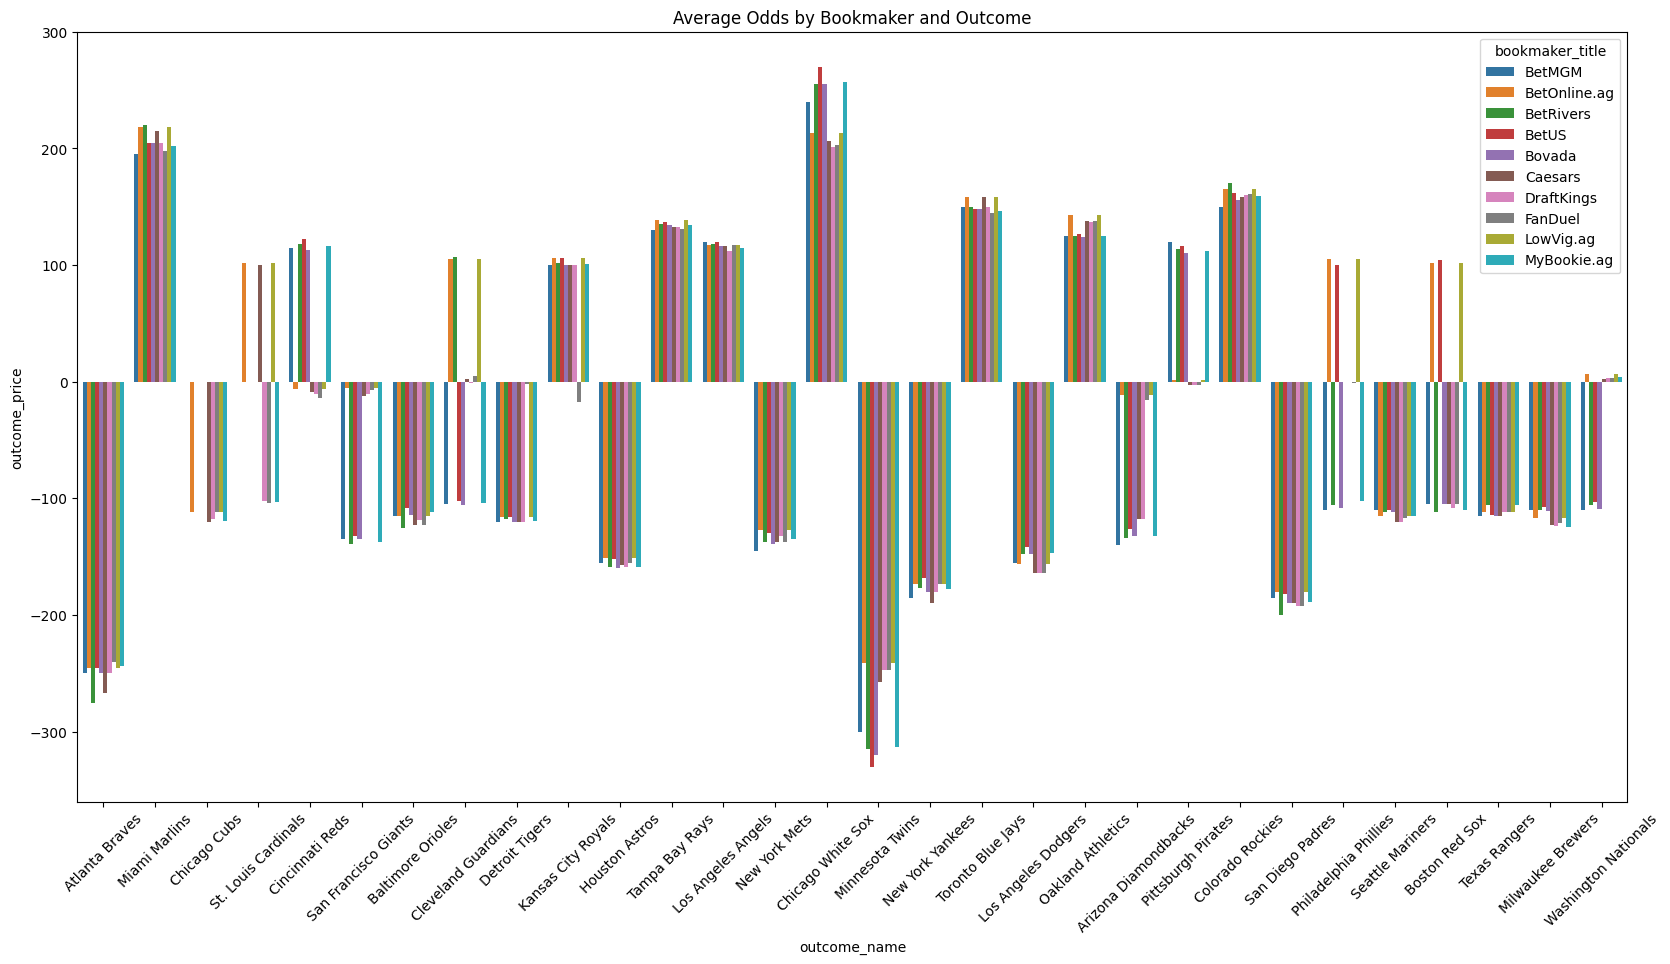

In [148]:
plt.figure(figsize=(20, 10))
sns.barplot(data=df_avg_odds, x='outcome_name', y='outcome_price', hue='bookmaker_title')
plt.title('Average Odds by Bookmaker and Outcome')
plt.xticks(rotation=45)
plt.show()

In [95]:
# Groups and aggregates a processed Dataframe to find the average odds of each position of each market of each game
def av_odds(df):
    key_fields = ['sport_key', 'sport_title', 'home_team', 'away_team', 'market_key', 'outcome_name','outcome_price']

    # Aggregate by mean
    df = df.groupby(key_fields, dropna=False).mean()
    df.sort_values(['home_team', 'away_team', 'market_key'], inplace=True)
    return df


In [ ]:
# Extracts the pinnacle odds from processed odds (function will return an empty df if eu odds are not part of input df)
def extract_pinnacle(odds):
        pinnacle_odds = odds.loc[odds['book_key'] == 'pinnacle']
        pinnacle_odds.reset_index(drop=True, inplace=True)
        return pinnacle_odds


In [ ]:
# Calculates the expected value with regard to the average odds, takes just book_odds as parameter as average odds are calculated directly from book odds
def avg_ev(book_odds):
        # Calculate average odds
        average_odds = av_odds(book_odds)

        # Key fields for merging
        key_fields = ['id', 'sport_key', 'sport_title', 'commence_time', 'home_team', 'away_team', 'market', 'position', 'point', 'num_outcomes', 'num_books']

        # Merge book odds with the average odds
        avg_merge = book_odds.merge(average_odds, how='inner', on=key_fields, suffixes=['_book', '_avg'], validate='m:1')

        # Calculate ev data
        avg_merge['ev_pct_avg'] = (avg_merge['fair_win_dec_avg'] * avg_merge['amount_to_win_line_book']) - ((1 - avg_merge['fair_win_dec_avg']) * 100)
        avg_merge['kelly_dec_avg'] = avg_merge['fair_win_dec_avg'] - ((1 - avg_merge['fair_win_dec_avg']) / (avg_merge['amount_to_win_line_book'] / 100))
        avg_merge['kelly_pct_avg'] = avg_merge['kelly_dec_avg'] * 100

        return avg_merge

In [ ]:
# Calculates the expected value with regard to the average odds, takes just book_odds as parameter as average odds are calculated directly from book odds
def avg_ev(book_odds):
        # Calculate average odds
        average_odds = av_odds(book_odds)

        # Key fields for merging
        key_fields = ['id', 'sport_key', 'sport_title', 'commence_time', 'home_team', 'away_team', 'market', 'position', 'point', 'num_outcomes', 'num_books']

        # Merge book odds with the average odds
        avg_merge = book_odds.merge(average_odds, how='inner', on=key_fields, suffixes=['_book', '_avg'], validate='m:1')

        # Calculate ev data
        avg_merge['ev_pct_avg'] = (avg_merge['fair_win_dec_avg'] * avg_merge['amount_to_win_line_book']) - ((1 - avg_merge['fair_win_dec_avg']) * 100)
        avg_merge['kelly_dec_avg'] = avg_merge['fair_win_dec_avg'] - ((1 - avg_merge['fair_win_dec_avg']) / (avg_merge['amount_to_win_line_book'] / 100))
        avg_merge['kelly_pct_avg'] = avg_merge['kelly_dec_avg'] * 100

        return avg_merge

In [ ]:
# Merge the avg ev and pinnacle ev dataframes into one
def merge_ev(avg_merge, pinnacle_merge):
        # Key fields for merging
        key_fields = ['id', 'sport_key', 'sport_title', 'commence_time', 'home_team', 'away_team', 'book_key', 'book_title', 'market', 'position', 'line_book', 'point', 'num_outcomes', 'above_below_book', 'width_book', 'vig_win_dec_book', 'fair_win_dec_book', 'fair_line_book', 'amount_to_win_line_book', 'amount_to_win_fair_book', 'vig_dec_book', 'vig_pct_book']

        # Merge the dataframes (left merge because there are more averages than pinnacle odds and we don't want to lose those)
        final_merge = avg_merge.merge(pinnacle_merge.drop(columns=['num_books']), how='left', on=key_fields, suffixes=['_avg', '_pinnacle'])

        return final_merge

In [ ]:
# Takes API parameters and the desired type of expected value and returns a complete Dataframe with ev fields
def api_to_ev(api_key, sports=None, regions=['us'], markets=['h2h'], ev_type='both'):
        book_odds = api_to_processed_df(api_key=api_key, sports=sports, regions=regions, markets=markets)

        if ev_type == 'avg':
            ev = avg_ev(book_odds=book_odds)
        elif ev_type == 'pinnacle':
            if 'eu' not in regions:
                eu_odds = api_to_processed_df(api_key=api_key, sports=sports, regions=['eu'], markets=markets)
                pinnacle_odds = extract_pinnacle(eu_odds)
                ev = pinnacle_ev(book_odds=book_odds, pinnacle_odds=pinnacle_odds)
            else:
                pinnacle_odds = extract_pinnacle(book_odds)
                ev = pinnacle_ev(book_odds=book_odds, pinnacle_odds=pinnacle_odds)
        else: # assumed to be 'both'
            average = avg_ev(book_odds=book_odds)
            if 'eu' not in regions:
                eu_odds = api_to_processed_df(api_key=api_key, sports=sports, regions=['eu'], markets=markets)
                pinnacle_odds = extract_pinnacle(eu_odds)
                pinnacle = pinnacle_ev(book_odds=book_odds, pinnacle_odds=pinnacle_odds)
            else:
                pinnacle_odds = extract_pinnacle(book_odds)
                pinnacle = pinnacle_ev(book_odds=book_odds, pinnacle_odds=pinnacle_odds)
            ev = merge_ev(avg_merge=average, pinnacle_merge=pinnacle)

        return ev

In [ ]:
# Reads data from a JSON file and returns a complete Dataframe with ev fields (if ev_type 'pinnacle' is selected and file does not contain eu odds, df will be empty)
def file_to_ev(filename, ev_type='both'):
        book_odds = file_to_processed_df(filename)
        if ev_type == 'avg':
            ev = avg_ev(book_odds=book_odds)
        elif ev_type == 'pinnacle':
            pinnacle_odds = extract_pinnacle(book_odds)
            ev = pinnacle_ev(book_odds=book_odds, pinnacle_odds=pinnacle_odds)
        else: # assumed to be 'both'
            average = avg_ev(book_odds=book_odds)
            pinnacle_odds = extract_pinnacle(book_odds)
            pinnacle = pinnacle_ev(book_odds=book_odds, pinnacle_odds=pinnacle_odds)
            ev = merge_ev(avg_merge=average, pinnacle_merge=pinnacle)

        return ev

In [ ]:
# Filters a Dataframe of ev odds based on several optional parameters
def filter_ev(odds, pref_ev_filter, sports=None, markets=None, days_from_now=None, books=None, min_odds=None, max_odds=None, max_width=None, max_vig_pct=None, min_ev_pct=None, min_num_books=None):
        if sports is not None:
            odds = odds.loc[odds['sport_key'].isin(sports)]
        if markets is not None:
            odds = odds.loc[odds['market'].isin(markets)]
        if days_from_now is not None:
            date = pytz.UTC.localize(datetime.datetime.now())+datetime.timedelta(days=days_from_now)
            odds = odds.loc[odds['commence_time'].apply(lambda t: dateutil.parser.isoparse(t)) <=  date]
        if books is not None:
            odds = odds.loc[odds['book_key'].isin(books)]
        if min_odds is not None:
            odds = odds.loc[odds['line_book'] >= min_odds]
        if max_odds is not None:
            odds = odds.loc[odds['line_book'] <= max_odds]
        if max_width is not None:
            odds = odds.loc[odds['num_outcomes'] == 2]
            if pref_ev_filter == 'both' or pref_ev_filter == 'avg':
                odds = odds.loc[odds['width_avg'] <= max_width]
            if pref_ev_filter == 'both' or pref_ev_filter == 'pinnacle':
                odds = odds.loc[odds['width_pinnacle'] <= max_width]
        if max_vig_pct is not None:
            if pref_ev_filter == 'both' or pref_ev_filter == 'avg':
                odds = odds.loc[odds['vig_pct_avg'] <= max_vig_pct]
            if pref_ev_filter == 'both' or pref_ev_filter == 'pinnacle':
                odds = odds.loc[odds['vig_pct_pinnacle'] <= max_vig_pct]
        if min_ev_pct is not None:
            if pref_ev_filter == 'both' or pref_ev_filter == 'avg':
                odds = odds.loc[odds['ev_pct_avg'] >= min_ev_pct]
            if pref_ev_filter == 'both' or pref_ev_filter == 'pinnacle':
                odds = odds.loc[odds['ev_pct_pinnacle'] >= min_ev_pct]
        if min_num_books is not None:
            odds = odds.loc[odds['num_books'] >= min_num_books]

        odds.reset_index(drop=True, inplace=True)

        return odds

In [ ]:
# Sorts a Dataframe of ev odds by a field
def sort_ev(odds, sortby, ascending, pref_ev_sort='avg'):
        if sortby == 'commence_time':
            odds.sort_values(['commence_time'], ascending=ascending, inplace=True)
        elif sortby == 'line':
            odds.sort_values(['line_book'], ascending=ascending, inplace=True)
        elif sortby == 'width':
            if pref_ev_sort == 'avg':
                odds.sort_values(['width_avg'], ascending=ascending, inplace=True)
            if pref_ev_sort == 'pinnacle':
                odds.sort_values(['width_pinnacle'], ascending=ascending, inplace=True)
        elif sortby == 'ev_pct':
            if pref_ev_sort == 'avg':
                odds.sort_values(['ev_pct_avg'], ascending=ascending, inplace=True)
            if pref_ev_sort == 'pinnacle':
                odds.sort_values(['ev_pct_pinnacle'], ascending=ascending, inplace=True)
        if sortby == 'kelly_pct':
            if pref_ev_sort == 'avg':
                odds.sort_values(['kelly_pct_avg'], ascending=ascending, inplace=True)
            if pref_ev_sort == 'pinnacle':
                odds.sort_values(['kelly_pct_pinnacle'], ascending=ascending, inplace=True)

        if sortby == 'default':
            odds.sort_values(['commence_time', 'id', 'book_key', 'market'], inplace=True)

        odds.reset_index(drop=True, inplace=True)

        return odds

In [ ]:
# Simplify the dataframe into a more easily consumable format
def cleanup_ev(odds, ev_type):
        fields_keep = ['sport_title', 'commence_time', 'home_team', 'away_team', 'book_title', 'market', 'position', 'line_book', 'point', 'num_books']

        if ev_type == 'both' or ev_type == 'avg':
            add_fields = ['fair_line_avg', 'width_avg', 'vig_pct_avg', 'ev_pct_avg', 'kelly_pct_avg']
            fields_keep.extend(add_fields)
        if ev_type == 'both' or ev_type == 'pinnacle':
            add_fields = ['fair_line_pinnacle', 'width_pinnacle', 'vig_pct_pinnacle', 'ev_pct_pinnacle', 'kelly_pct_pinnacle']
            fields_keep.extend(add_fields)


        odds = odds[fields_keep]
        odds = odds.round(2)
        return odds


In [ ]:
########################################################################################################################################
    #
    # BEGIN data() main code body
    #
    ########################################################################################################################################

    # Check inputs for api call and/or filename
if api_key is None and filename is None:
        raise SystemExit("Error: API key or filename must be specified\n")

if sports is None:
        if filename is None and api_key is not None:
            sports = get_sports(api_key=api_key)
elif sports is not None and (type(sports) != list or len(sports) == 0):
        raise TypeError("parameter 'sports' must be a list of valid sport IDs or None value. Refer to documentation for information on valid sport IDs\n")

if type(regions) != list or len(regions) == 0:
        raise TypeError("parameter 'regions' must be a list of valid regions. Refer to documentation for information on valid regions\n")

region_list = ['us']
for region in regions:
        if region not in region_list:
            raise SystemExit("Error: one or more regions are invalid. Refer to documentation for information on valid regions\n")

if type(markets) != list or len(markets) == 0:
        raise TypeError("parameter 'markets' must be a list of valid markets. Refer to documentation for information on valid markets\n")

market_list = ['h2h', 'spreads', 'totals']
for market in markets:
        if market not in market_list:
            raise SystemExit("Error: one or more markets are invalid. Refer to documentation for information on valid markets\n")

ev_types = ['avg', 'pinnacle', 'both']
if ev_type not in ev_types:
        raise SystemExit("Error: ev_type must be one of: 'avg', 'pinnacle', 'both' or be left blank")

NameError: name 'api_key' is not defined

In [ ]:
# Get ev data frame
    if filename is not None:
        df = file_to_ev(filename=filename, ev_type=ev_type)
    else:
        df = api_to_ev(api_key=api_key, sports=sports, regions=regions, markets=markets, ev_type=ev_type)

    # If recommended is on, reassign everything to values to give recommended bets (except books because a user should still be able to customize which books are displayed)
    if type(recommended) != bool:
        print("parameter 'recommended' must be a boolean. Default value is false")
        recommended = False
    if recommended:
        days_from_now = 2
        min_odds = -200
        max_odds = 200
        max_width = 45
        min_ev_pct = 1
        min_num_books = 4
        pref_ev_filter = 'both'
        sortby = 'ev_pct'
        ascending = False
        pref_ev_sort = 'avg'
        expanded = False

In [ ]:
# Check inputs for filter
    if days_from_now is not None and (type(days_from_now) != int or days_from_now < 0):
        if type(days_from_now) == float:
            days_from_now = int(days_from_now)
        else:
            print("parameter 'days_from_now' must be an integer >= 0. Filter parameter ignored")
            days_from_now = None

    if books is not None:
        if type(books) != list:
            print("parameter 'books' must be a list of valid book keys. Refer to documentation for information on valid books. Filter parameter ignored")
            books = None
        else:
            book_list = df['book_key'].unique().tolist()
            for book in list(books):
                if book not in book_list:
                    books.remove(book)
                    print(f'{book} is not a valid book. Data filtered by other specified books')
            if len(books) == 0:
                books = None

    if min_odds is not None and type(min_odds) != int and type(min_odds) != float:
        print("parameter 'min_odds' must be an integer or float. Filter parameter ignored")
        min_odds = None

    if max_odds is not None and type(max_odds) != int and type(max_odds) != float:
        print("parameter 'max_odds' must be an integer or float. Filter parameter ignored")
        max_odds = None

    if max_width is not None and type(max_width) != int and type(max_width) != float:
        print("parameter 'max_width' must be an integer or float. Filter parameter ignored")
        max_width = None

    if max_vig_pct is not None and type(max_vig_pct) != int and type(max_vig_pct) != float:
        print("parameter 'max_vig_pct' must be an integer or float. Filter parameter ignored")
        max_vig_pct = None

    if min_ev_pct is not None and type(min_ev_pct) != int and type(min_ev_pct) != float:
        print("parameter 'min_ev_pct' must be an integer or float. Filter parameter ignored")
        min_ev_pct = None

    if min_num_books is not None and type(min_num_books) != int and type(min_num_books) != float:
        print("parameter 'min_num_books' must be an integer or float. Filter parameter ignored")
        min_num_books = None

    if pref_ev_filter not in ev_types:
        print("parameter 'pref_ev_filter' must be one of: 'avg', 'pinnacle', 'both' or be left blank. Value defaults to 'both'")
        pref_ev_filter = 'both'
    elif pref_ev_filter == 'avg' and ev_type == 'pinnacle':
        print("parameter 'pref_ev_filter' cannot be 'avg' when parameter 'ev_type' is 'pinnacle'. Value defaults to 'pinnacle'")
        pref_ev_filter = 'pinnacle'
    elif pref_ev_filter == 'pinnacle' and 'ev_type' == 'avg':
        print("parameter 'pref_ev_filter' cannot be 'pinnacle' when parameter 'ev_type' is 'avg'. Value defaults to 'avg'")
        pref_ev_filter = 'avg'

    if ev_type == 'both':
        if pref_ev_filter is None:
            pref_ev_filter = 'both'
    else:
        pref_ev_filter = ev_type


In [ ]:
 # Filter the df
    df = filter_ev(df, pref_ev_filter, sports=sports, markets=markets, days_from_now=days_from_now, books=books, min_odds=min_odds, max_odds=max_odds, max_width=max_width, max_vig_pct=max_vig_pct, min_ev_pct=min_ev_pct, min_num_books=min_num_books)


In [ ]:
# Check inputs for sorting
    sort_options = ['commence_time', 'line', 'width', 'ev_pct', 'kelly_pct', 'default']
    if type(sortby) != str and sortby not in sort_options:
        print("parameter 'sortby' invalid. Refer to documentation for valid 'sortby' values. Filter parameter ignored")
        sortby = 'default'

    if ascending is not None and type(ascending) != bool:
        print("parameter 'ascending' must be a boolean. Default value used")
        ascending = False

    if pref_ev_sort is not None and (pref_ev_sort not in ev_types or pref_ev_sort == 'both'):
        print("parameter 'pref_ev_sort' must be 'avg' or 'pinnacle' or be left blank. Value defaults to 'avg'")
        pref_ev_sort = 'avg'
    elif pref_ev_sort == 'avg' and ev_type == 'pinnacle':
        print("parameter 'pref_ev_sort' cannot be 'avg' when parameter 'ev_type' is 'pinnacle'. Value defaults to 'pinnacle'")
        pref_ev_sort = 'pinnacle'
    elif pref_ev_sort == 'pinnacle' and 'ev_type' == 'avg':
        print("parameter 'pref_ev_sort' cannot be 'pinnacle' when parameter 'ev_type' is 'avg'. Value defaults to 'avg'")
        pref_ev_sort = 'avg'


In [ ]:
# Sort the df
    df = sort_ev(df, sortby=sortby, ascending=ascending, pref_ev_sort=pref_ev_sort)

In [ ]:
# If expanded is false, simplify the df
    if type(expanded) != bool:
        print("parameter 'expanded' must be a boolean. Value defaults to false.")
    if not expanded:
        df = cleanup_ev(df, ev_type=ev_type)

    return df